In [117]:
import pandas as pd
import json
import glob

# Load the JSON file
# Read all JSON files that start with "perplexity_"
json_files = glob.glob('../perplexity_*.json')

# Combine data from all JSON files
data = []
for file in json_files:
    with open(file, 'r') as f:
        data.extend(json.load(f))

# Create a DataFrame
df = pd.DataFrame(data)

# Display the head of the DataFrame
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286
...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175


In [118]:
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286
...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175


In [119]:
# Extract the .../prompts_Z/.../PX_Y.txt part and create columns for X, Y, and Z
df[['Z', 'X', 'Y']] = df['file'].str.extract(r'-(\w+)_P(\d+)_(\d+)\.txt')

# Convert X and Y to integers for consistency
df['X'] = df['X'].astype(int)
df['Y'] = df['Y'].astype(int)

# Display the updated DataFrame
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity,Z,X,Y
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059,no_prefix,0,0
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803,no_prefix,1,0
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881,no_prefix,2,0
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155,no_prefix,3,0
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286,no_prefix,4,0
...,...,...,...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254,wikipedia,20,3
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655,wikipedia,20,4
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291,wikipedia,20,5
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175,wikipedia,20,6


In [166]:
import plotly.express as px

# Create a boxplot for 'longest_low_perplexity_length' grouped by 'Z'
fig = px.box(df, x='Z', y='avg_perplexity', 
             title='Distribution of Longest Low Perplexity Length by Prefix Type',
             labels={'avg_perplexity': 'Average perplexity', 'Z': 'Prefix Type'})

# Update layout
fig.update_layout(
    title='Average Perplexity per prefix',
    xaxis_title='Prefix',
    yaxis_title='Average Perplexity',
    barmode='group',  # Group bars by X value
    legend_title='Prefix type'
)

In [167]:
import plotly.express as px

# Create a boxplot for 'longest_low_perplexity_length' grouped by 'Z'
fig = px.box(df, x='Z', y='longest_low_perplexity_length', 
             title='Distribution of Longest Low Perplexity Length by Prefix Type',
             labels={'longest_low_perplexity_length': 'Longest Low Perplexity Length', 'Z': 'Prefix Type'})

# Update layout
fig.update_layout(
    title='Longest low-perplexity length per prefix',
    xaxis_title='Prefix',
    yaxis_title='Longest low perplexity',
    barmode='group',  # Group bars by X value
    legend_title='Prefix type'
)

fig.update_xaxes(tickvals=grouped['Z'], ticktext=["According to literature, ...", "No prefixes", "According to Wikipedia, ..."])

fig.show()

(array([125.,  78.,   3.,   0.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([ 17.5570592 ,  48.85453634,  80.15201348, 111.44949062,
        142.74696777, 174.04444491, 205.34192205, 236.63939919,
        267.93687633, 299.23435347, 330.53183061]),
 <BarContainer object of 10 artists>)

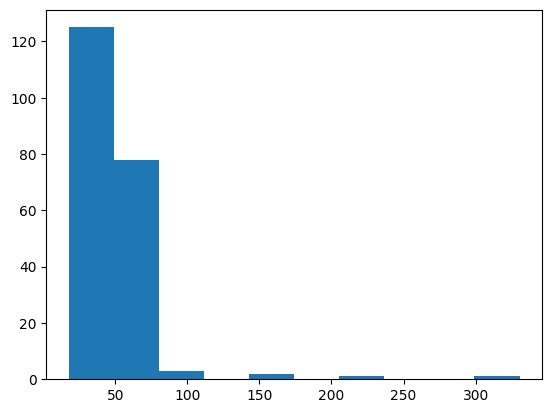

In [139]:
import matplotlib.pyplot as plt

import plotly.express as px

# Create a histogram for each value of Z
fig = px.histogram(df, x='avg_perplexity', color='Z', barmode='overlay', 
                   title='Distribution of Average Perplexity by Z',
                   labels={'avg_perplexity': 'Average Perplexity', 'Z': 'Prefix Type'})

# Show the plot
fig.show()

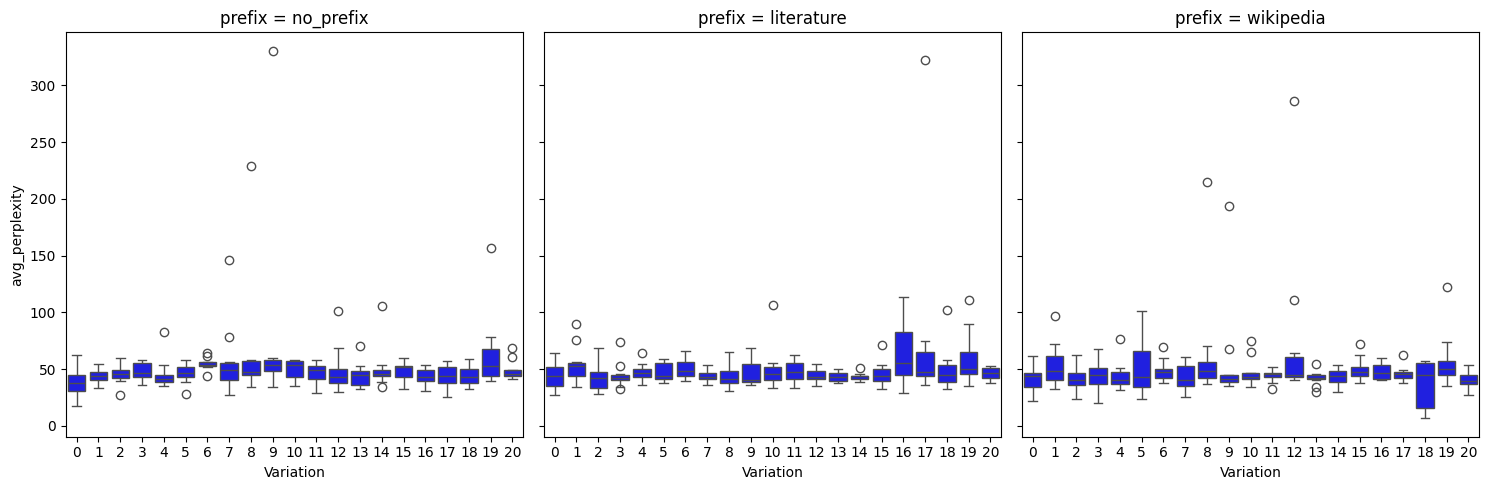

In [173]:
# Create subplots for each value of Z
fig, axes = plt.subplots(1, len(unique_z_values), figsize=(15, 5), sharey=True)

per = 'avg_perplexity' #longest_low_perplexity_length

for ax, z_value in zip(axes, unique_z_values):
    # Filter data for the current Z value
    z_data = df[df['Z'] == z_value]
    
    # Create a boxplot
    sns.boxplot(data=z_data, x='X', y=per, ax=ax, color='blue')
    
    # Add labels and title
    ax.set_title(f'prefix = {z_value}')
    ax.set_xlabel('Variation')
    ax.set_ylabel(per)

plt.tight_layout()
plt.show()


In [160]:
df.sort_values(by='longest_low_perplexity_length', ascending=False).iloc[0, 0]

'outputs/perplexity/prompts_morphine/pythia-2.8b-wikipedia_P10_1.txt'